<a href="https://colab.research.google.com/github/nmatsumoto-lgtm/study-KIKAGAKU/blob/main/%E4%B8%8D%E5%8B%95%E7%94%A3%E4%BE%A1%E6%A0%BC%E4%BA%88%E6%B8%AC%E3%82%A2%E3%83%97%E3%83%AA_Ver_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install lightgbm==4.5.0 optuna==3.6.1 joblib pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.4 MB/s eta 0:00:00


In [4]:
from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass


import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error
from joblib import dump
from optuna.samplers import TPESampler

In [5]:
# ===== 再現性セット（最上部の import の後に）=====
import os, random
SEED = 42  # ← 好きな固定値（既存の SEED=0 があれば 0 のままでもOK）
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
import os, re
import numpy as np
import pandas as pd

# 1) アップした元CSVのパス（ファイル名は自分のに合わせて変更）
SRC = "/content/平均売買㎡単価推移_東京都中央区.csv"

# 2) 出力先（学習コードが読む場所）
DST_DIR = "data/external"
DST = f"{DST_DIR}/avg_psm.csv"
os.makedirs(DST_DIR, exist_ok=True)

# 3) 読み込み
df = pd.read_csv(SRC)

# 4) 列の推定（period or year/month, そして avg_psm_yen）
cols_lower = {c.lower(): c for c in df.columns}

def pick_price_col(df):
    # まず既に英名があればそれを使う
    if "avg_psm_yen" in cols_lower:
        return cols_lower["avg_psm_yen"]
    # 日本語っぽい列名の自動検出（「平均」「㎡」「単価」「売買」などを含む列）
    for c in df.columns:
        s = str(c)
        if ("㎡" in s or "平米" in s or "m2" in s.lower()) and ("単価" in s or "価格" in s or "売買" in s):
            return c
    # 予備
    for c in df.columns:
        if "psm" in c.lower():
            return c
    raise ValueError("平均㎡単価の列が見つかりません。'avg_psm_yen' または日本語列名（例: '平均㎡売買単価'）を用意してください。")

def to_num(x):
    # "1,647,000 円" みたいな表記を数値化
    return (str(x)
            .replace(",", "")
            .replace("円", "")
            .replace("¥", "")
            .strip())

price_col = pick_price_col(df)
df[price_col] = pd.to_numeric(df[price_col].map(to_num), errors="coerce")

# period or year/month を作成
if "period" in cols_lower:
    period_col = cols_lower["period"]
    df["period"] = pd.to_numeric(df[period_col], errors="coerce").astype("Int64")
else:
    # 年月の列名を推測（year, month / 年, 月, 年月など）
    def pick_year_col():
        for k in ["year", "年"]:
            if k in cols_lower: return cols_lower[k]
        for c in df.columns:
            if re.search(r"年", str(c)): return c
        return None
    def pick_month_col():
        for k in ["month", "月"]:
            if k in cols_lower: return cols_lower[k]
        for c in df.columns:
            if re.search(r"月", str(c)): return c
        return None
    ycol = pick_year_col()
    mcol = pick_month_col()
    if ycol is not None and mcol is not None:
        yy = pd.to_numeric(df[ycol], errors="coerce").astype("Int64")
        mm = pd.to_numeric(df[mcol], errors="coerce").astype("Int64")
        df["period"] = (yy*100 + mm).astype("Int64")
    else:
        # "YYYYMM" 形式の列（例: 年月, yyyymm）を探す
        c_ym = None
        for c in df.columns:
            s = str(c).lower()
            if "yyyymm" in s or "年月" in s:
                c_ym = c; break
        if c_ym is None:
            raise ValueError("period か year/month（または 年/月/年月）の列が見つかりません。")
        df["period"] = pd.to_numeric(df[c_ym], errors="coerce").astype("Int64")

# 5) 最低限の2列だけに整形して保存
out = df[["period", price_col]].rename(columns={price_col: "avg_psm_yen"}).dropna()
out["period"] = out["period"].astype(int)
out["avg_psm_yen"] = out["avg_psm_yen"].astype(float)
out = out.sort_values("period")

out.to_csv(DST, index=False, encoding="utf-8-sig")
print("Saved ->", DST)
print(out.head())

Saved -> data/external/avg_psm.csv
   period  avg_psm_yen
0  202406    1290000.0
1  202408    1330000.0
2  202410    1380000.0
3  202412    1440000.0
4  202502    1520000.0


In [7]:
SEED = 0
np.random.seed(SEED)

In [8]:
IN = Path("data/interim/train_tabular.csv")
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [9]:
# === 追加（先頭の定数定義あたり）========================
IDX_CSV = Path("data/external/avg_psm.csv")  # 平均㎡単価CSV
USE_DEFLATE = True  # ← True: ②デフレート学習を有効化 / False: ①の特徴量化のみ
# =======================================================

In [10]:
# === 追加：指数CSVを読み込み、月次(YYYYMM)に整えて返す =========
def _load_avg_psm_monthly(csv_path: Path) -> pd.DataFrame:
    idx = pd.read_csv(csv_path)

    # period が無ければ year,month から作成
    cols = {c.lower(): c for c in idx.columns}
    if "period" not in cols:
        ycol = cols.get("year"); mcol = cols.get("month")
        if ycol is None or mcol is None:
            raise ValueError("avg_psm.csv には period か year,month が必要です。")
        idx["period"] = idx[ycol].astype(int) * 100 + idx[mcol].astype(int)

    # 月次にリサンプリング（2か月置き→月次へ・線形補間）
    idx["ym"] = pd.to_datetime(idx["period"].astype(str), format="%Y%m")
    idx = (idx[["ym", "avg_psm_yen"]]
             .set_index("ym")
             .resample("MS")
             .interpolate("time")
             .ffill()
             .reset_index())
    idx["period"] = (idx["ym"].dt.year * 100 + idx["ym"].dt.month).astype(int)

    # MoM/YoYなど派生（任意）
    idx = idx.sort_values("period").reset_index(drop=True)
    idx["log_idx_psm"] = np.log(idx["avg_psm_yen"].astype(float))
    idx["idx_mom"] = idx["avg_psm_yen"].pct_change().fillna(0.0)
    idx["idx_yoy"] = idx["avg_psm_yen"].pct_change(12).fillna(0.0)
    return idx[["period", "avg_psm_yen", "log_idx_psm", "idx_mom", "idx_yoy"]]
# =========================================================

def compute_calibration(period_arr, idx_csv: Path, smooth_months: int = 2) -> float:
    """
    学習末月の外部平均㎡単価と最新月の外部平均㎡単価の比（移動平均で平滑化）を返す。
    deflate有無に関わらず、最終の円スケールに掛けるだけでOK。
    """
    try:
        idx = _load_avg_psm_monthly(idx_csv).sort_values("period")
        last_train = int(np.max(period_arr))

        p_train = idx.loc[idx["period"] <= last_train, "avg_psm_yen"]
        if len(p_train) == 0:
            return 1.0
        base = float(p_train.tail(smooth_months).mean())

        latest = float(idx["avg_psm_yen"].tail(smooth_months).mean())
        return latest / base if base > 0 else 1.0
    except Exception:
        return 1.0

In [11]:
# === 中央区 5エリア：駅→エリアの固定マップ ===
STATION_TO_AREA = {
    # ① 銀座・京橋
    "銀座": "銀座・京橋",
    "東銀座": "銀座・京橋",
    "銀座一丁目": "銀座・京橋",
    "京橋(東京)": "銀座・京橋",
    "宝町(東京)": "銀座・京橋",
    "新橋": "銀座・京橋",
    "汐留": "銀座・京橋",
    "東京": "銀座・京橋",  # 日本橋側に寄せたい場合は「日本橋・人形町」へ変更可

    # ② 日本橋・人形町
    "日本橋(東京)": "日本橋・人形町",
    "三越前": "日本橋・人形町",
    "新日本橋": "日本橋・人形町",
    "茅場町": "日本橋・人形町",
    "人形町": "日本橋・人形町",
    "水天宮前": "日本橋・人形町",
    "浜町": "日本橋・人形町",
    "東日本橋": "日本橋・人形町",
    "小伝馬町": "日本橋・人形町",
    "馬喰横山": "日本橋・人形町",
    "馬喰町": "日本橋・人形町",

    # ③ 月島・勝どき・晴海
    "月島": "月島・勝どき・晴海",
    "勝どき": "月島・勝どき・晴海",

    # ④ 築地・八丁堀
    "築地": "築地・八丁堀",
    "築地市場": "築地・八丁堀",
    "新富町(東京)": "築地・八丁堀",
    "八丁堀(東京)": "築地・八丁堀",
}

AREA_LIST = ["銀座・京橋", "日本橋・人形町", "月島・勝どき・晴海", "築地・八丁堀", "佃・新川・湊", "その他"]

def station_to_area(station_name: str) -> str:
    """駅名を5エリアに変換。未登録は 'その他'。"""
    if not isinstance(station_name, str) or station_name.strip() == "":
        return "その他"
    return STATION_TO_AREA.get(station_name.strip(), "その他")

In [12]:
# ============================
# 1) データ読み込み & 追加特徴量
# ============================

def _oof_target_median(df: pd.DataFrame, key: str, y: np.ndarray, n_splits: int = 5) -> np.ndarray:
    """キー列ごとの OOF 中央値エンコーディング（リーク防止）。
    戻り値は各行に対応する OOF 推定値（学習折ごとに学習外の中央値を使う）。
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        med = (
            pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
            .groupby(key)["y"].median()
        )
        oof[va_idx] = df.iloc[va_idx][key].map(med).fillna(med.median()).values
    return oof

def _oof_target_mean(df, key, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        m = (pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
             .groupby(key)["y"].mean())
        oof[va_idx] = df.iloc[va_idx][key].map(m).fillna(m.mean()).values
    return oof

def build_table_and_features() -> tuple[pd.DataFrame, list[str], list[str], list[str], list[int]]:
    df = pd.read_csv(IN)

    # ===== 対数ターゲット =====
    y = df["price_yen"].astype(float).values
    # ★ 追加：指数CSVを読み込み & マージ
    idx = _load_avg_psm_monthly(IDX_CSV)

    # 学習データ側 period が無ければ作成（あなたのCSVには既にありますが保険）
    if "period" not in df.columns and {"year","month"} <= set(df.columns):
        df["period"] = df["year"].astype(int)*100 + df["month"].astype(int)

    # マージ（相場水準をくっつける）
    df = df.merge(idx, on="period", how="left")

    # === ViT画像特徴（駅ごと）を追加 ===
    df, vit_cols = add_vit_features_to_df(df)   # ← これを追加

    # 欠損は前方/後方で埋める（学習期間内なら埋まります）
    for c in ["avg_psm_yen","log_idx_psm","idx_mom","idx_yoy"]:
        df[c] = df[c].fillna(method="ffill").fillna(method="bfill")

    # ★ ここが“②デフレート学習”の切替ポイント
    if USE_DEFLATE:
        # 相場水準(avg_psm)を引いた「相対価格（対数）」を学習
        y_log = np.log1p(y) - np.log(df["avg_psm_yen"].astype(float).values)
    else:
        # 従来どおり
        y_log = np.log1p(y)

    # # ===== 対数ターゲット =====
    # y = df["price_yen"].astype(float).values
    # y_log = np.log1p(y)

    # ===== 5エリアを駅から自動付与（入力は駅のまま）=====
    df["area_group"] = df["station"].astype(str).apply(station_to_area)

    # ===== 追加特徴量 =====
    df["access_score"] = 1.0 / (1.0 + df["walk_min"].astype(float))
    df["sqrt_area"]    = np.sqrt(np.clip(df["area_sqm"].astype(float), 0, None))
    df["log_area"]     = np.log1p(np.clip(df["area_sqm"].astype(float), 0, None))
    df["age_sqrt"]     = np.sqrt(np.clip(df["築年数"].astype(float), 0, None))
    df["area_x_access"]= df["area_sqm"].astype(float) * df["access_score"].astype(float)

    # ===== 頻度特徴量 =====
    station_cnt = df["station"].value_counts()
    layout_cnt  = df["layout"].value_counts()
    area_cnt    = df["area_group"].value_counts()

    df["station_count"] = df["station"].map(station_cnt).fillna(0).astype(int)
    df["layout_count"]  = df["layout"].map(layout_cnt).fillna(0).astype(int)
    df["area_count"]    = df["area_group"].map(area_cnt).fillna(0).astype(int)

    # ===== OOF 目標エンコード（対数ターゲットで中央値）=====
    df["station_oof_median_log"] = _oof_target_median(df, "station",     y_log)
    df["layout_oof_median_log"]  = _oof_target_median(df, "layout",      y_log)
    df["area_oof_median_log"]    = _oof_target_median(df, "area_group",  y_log)

    # ===== OOF 目標エンコード（対数ターゲットで平均）=====  ←★ ここを追加
    df["station_oof_mean_log"] = _oof_target_mean(df, "station",    y_log)
    df["layout_oof_mean_log"]  = _oof_target_mean(df, "layout",     y_log)
    df["area_oof_mean_log"]    = _oof_target_mean(df, "area_group", y_log)


    # ===== 推論用に学習時統計を準備 =====
    station_med_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].median().to_dict()
    )
    layout_med_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].median().to_dict()
    )
    area_med_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].median().to_dict()
    )

    # ←★ ここから “平均” を追加
    station_mean_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].mean().to_dict()
    )
    layout_mean_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].mean().to_dict()
    )
    area_mean_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].mean().to_dict()
    )

    global_station_med = float(np.median(list(station_med_map.values()))) if len(station_med_map) else float(np.median(y_log))
    global_layout_med  = float(np.median(list(layout_med_map.values())))  if len(layout_med_map)  else float(np.median(y_log))
    global_area_med    = float(np.median(list(area_med_map.values())))    if len(area_med_map)    else float(np.median(y_log))

    # 参考：平均の“全体値”も欲しければ
    global_station_mean = float(np.mean(list(station_mean_map.values()))) if len(station_mean_map) else float(np.mean(y_log))
    global_layout_mean  = float(np.mean(list(layout_mean_map.values())))  if len(layout_mean_map)  else float(np.mean(y_log))
    global_area_mean    = float(np.mean(list(area_mean_map.values())))    if len(area_mean_map)    else float(np.mean(y_log))

    # ===== カテゴリ列（area を先頭に追加）=====
    feat_cat = ["area_group", "station", "layout"]

    # ===== 数値列 =====
    feat_num_base = ["walk_min", "築年数", "area_sqm"]
    feat_num_extra = [
        "access_score", "sqrt_area", "log_area", "age_sqrt",
        "area_x_access",
        "station_count", "layout_count", "area_count",
        "station_oof_median_log", "layout_oof_median_log", "area_oof_median_log",
        "station_oof_mean_log", "layout_oof_mean_log", "area_oof_mean_log",
        # ★ 追加：指数の特徴量（①）
        "log_idx_psm",   # 水準（対数）
        "idx_mom",       # 前月比
        "idx_yoy",       # 前年同月比
    ]
    feat_num_extra += vit_cols   # ← これを追加
    feat_num_all = feat_num_base + feat_num_extra

    # 単調制約を「名前で」安全に指定
    mono_dict = {name: 0 for name in feat_num_all}
    mono_dict.update({
        "walk_min": -1,      # 遠いほど↓
        "築年数": -1,         # 古いほど↓
        "area_sqm": +1,      # 広いほど↑
        # ← 派生も一貫させる
        "access_score": +1,  # 駅近スコアが高いほど↑（walk_minと反対符号に注意だが整合的）
        "sqrt_area": +1,
        "log_area": +1,
        "age_sqrt": -1,
     })
    monotone_constraints = [0] * len(feat_cat) + [mono_dict[c] for c in feat_num_all]

    # # ===== 単調性制約（[cat..., num...] の順）=====
    # n_cat = len(feat_cat)
    # # walk_min↓, 築年数↓, area_sqm↑、その他は制約なし
    # mono_num = [-1, -1, +1] + [0] * (len(feat_num_all) - 3)
    # monotone_constraints = [0] * n_cat + mono_num

    # ===== ここから：新しいほど重くする sample_weight =====
    # 年月を「通算月」に変換（最新月との差＝どれだけ古いか）
    year_s  = pd.to_numeric(df["year"],  errors="coerce").astype(int)
    month_s = pd.to_numeric(df["month"], errors="coerce").astype(int)

    latest_m = int(year_s.max())*12 + int(month_s.max())          # スカラ
    this_m   = (year_s*12 + month_s)                               # Series（ベクトル計算）
    months_old = (latest_m - this_m).clip(lower=0)

    HALF_LIFE_MONTHS = 12.0  # 半減期（例：12ヶ月）。強めに効かせたいなら 6 にする等
    w = np.power(0.5, months_old / HALF_LIFE_MONTHS)
    w = np.clip(w, 0.2, None)  # 古すぎるデータにも最低限の重み（お好みで調整）
    sample_weight = w.values.astype(float)
    # ===== ここまで =====

    # ===== エンコードして学習用テーブル =====
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = oe.fit_transform(df[feat_cat].fillna("NA")).astype("int32")
    X_num = df[feat_num_all].astype(float).values
    X = np.hstack([X_cat, X_num])

    cat_cols = [f"cat__{c}" for c in feat_cat]
    num_cols = feat_num_all.copy()
    X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
    categorical_feature = cat_cols

    meta = {
        "feat_cat": feat_cat,
        "feat_num": num_cols,
        "categorical_feature": categorical_feature,
        "monotone_constraints": monotone_constraints,
    }

    # ===== 推論用マップ（station→area を含めて保存）=====
    infer_maps = {
        "station_count_map": station_cnt.to_dict(),
        "layout_count_map":  layout_cnt.to_dict(),
        "area_count_map":    area_cnt.to_dict(),

        "station_median_log_map": station_med_map,
        "layout_median_log_map":  layout_med_map,
        "area_median_log_map":    area_med_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # ↓↓↓ 追加（平均）
        "station_mean_log_map": station_mean_map,
        "layout_mean_log_map":  layout_mean_map,
        "area_mean_log_map":    area_mean_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # （必要なら平均の全体値も）
        "global_station_mean_log": global_station_mean,
        "global_layout_mean_log":  global_layout_mean,
        "global_area_mean_log":    global_area_mean,

        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,

        # 駅→エリア（推論で駅入力から自動付与）
        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,
    }

    avg_psm_arr = df["avg_psm_yen"].to_numpy() if "avg_psm_yen" in df.columns else None
    period_arr = df["period"].to_numpy().astype(int)

    # 返り値（従来どおり）
    return (X_df, y_log, categorical_feature, monotone_constraints, meta, oe,infer_maps, sample_weight, avg_psm_arr,np.log1p(df["price_yen"].astype(float).values),period_arr)

In [13]:
# ============================
# 2) Optuna でハイパラ探索（時系列CV）
# ============================
def tune_with_optuna(
    X_df, y_log, y_log_true, categorical_feature, monotone_constraints,
    period_arr,  # ★追加（YYYYMMの配列）
    n_trials=200, sample_weight=None, avg_psm=None
) -> tuple[dict, int, float]:

    from sklearn.model_selection import TimeSeriesSplit  # 先頭に移しても可

    # 並び替え（古い→新しい）
    order = np.argsort(period_arr)
    X_ord = X_df.iloc[order]
    y_ord = y_log[order]
    y_true_ord = y_log_true[order]
    w_ord = None if sample_weight is None else sample_weight[order]
    avg_ord = None if avg_psm is None else avg_psm[order]

    tscv = TimeSeriesSplit(n_splits=5)

    def objective(trial: optuna.Trial) -> float:
        params = {
            "objective": "rmse", "metric": "rmse",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "verbosity": -1, "seed": SEED,
            "monotone_constraints": monotone_constraints,
        }

        rmsles, best_iters = [], []
        for tr_rel, va_rel in tscv.split(X_ord):
            X_tr, X_va = X_ord.iloc[tr_rel], X_ord.iloc[va_rel]
            y_tr, y_va = y_ord[tr_rel], y_ord[va_rel]
            w_tr = None if w_ord is None else w_ord[tr_rel]
            w_va = None if w_ord is None else w_ord[va_rel]

            dtr = lgb.Dataset(
                X_tr, label=y_tr, weight=w_tr,
                categorical_feature=categorical_feature, free_raw_data=True
            )
            dva = lgb.Dataset(
                X_va, label=y_va, weight=w_va,
                categorical_feature=categorical_feature, free_raw_data=True
            )

            model = lgb.train(
                params, dtr, valid_sets=[dva],
                num_boost_round=4000,
                callbacks=[lgb.early_stopping(200, verbose=False)]
            )
            pred_log = model.predict(X_va, num_iteration=model.best_iteration)

            if USE_DEFLATE and (avg_ord is not None):
                # 相対ログ + 相場ログ → 円に戻してRMSLE
                yhat_yen  = np.expm1(pred_log + np.log(avg_ord[va_rel]))
                ytrue_yen = np.expm1(y_true_ord[va_rel])
                rmsle = float(np.sqrt(mean_squared_log_error(ytrue_yen, yhat_yen)))
            else:
                rmsle = float(np.sqrt(mean_squared_log_error(np.expm1(y_va), np.expm1(pred_log))))

            rmsles.append(rmsle)
            best_iters.append(model.best_iteration)

        trial.set_user_attr("best_iters", best_iters)
        return float(np.mean(rmsles))

    study = optuna.create_study(direction="minimize",sampler=TPESampler(seed=SEED))
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_iters_list = study.best_trial.user_attrs.get("best_iters", [1000])
    best_round = int(np.clip(np.mean(best_iters_list), 100, 4000))
    best_score = study.best_value
    return best_params, best_round, best_score

In [14]:
!pip -q install transformers==4.44.2 timm pillow requests mercantile scikit-learn tqdm joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.7 MB/s eta 0:00:00


In [30]:
import os, time, io, math, json, re, hashlib, random
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import requests
from PIL import Image
import mercantile
from tqdm import tqdm
from joblib import dump, load

import torch
from transformers import AutoImageProcessor, ViTModel
from sklearn.decomposition import PCA

# 既存の SEED を流用（無ければ固定）
try:
    SEED
except NameError:
    SEED = 42
np.random.seed(SEED); random.seed(SEED)
torch.manual_seed(SEED)

# ===== 1) パスと定数 ==========================================================
DATA_EXT = Path("data/external"); DATA_EXT.mkdir(parents=True, exist_ok=True)
IMG_CACHE_DIR = DATA_EXT / "gsi_tiles"; IMG_CACHE_DIR.mkdir(parents=True, exist_ok=True)
EMBED_DIR = DATA_EXT / "img_embed"; EMBED_DIR.mkdir(parents=True, exist_ok=True)
EMBED_PARQUET = DATA_EXT / "img_vit_pca.parquet"
PCA_PATH = Path("models/vit_pca.joblib"); PCA_PATH.parent.mkdir(parents=True, exist_ok=True)

STATIONS_GEO_CSV = DATA_EXT / "stations_geo.csv"  # 駅の緯度経度キャッシュ
GSI_URL = "https://cyberjapandata.gsi.go.jp/xyz/ort/{z}/{x}/{y}.jpg"  # 航空写真（オルソ）

# タイル設定：ズーム18で 3x3 を貼り合わせ→中央を 512x512 にクロップ
ZOOM = 18
GRID = 3               # 3x3
TILE_SIZE = 256        # GSIタイルは256px
CROP_PX = 512          # 中央を切り出すサイズ

UA = "ChuoWardPriceModel/1.0 (contact: your-email@example.com)"  # 利用規約に沿ってUA表記
REQ_TIMEOUT = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ===== 2) 駅ジオコーディング（Nominatim）======================================
def _nominatim_search_station(name: str) -> Tuple[float, float] | None:
    """
    OSM Nominatimで駅名から緯度経度を引く（日本限定）。結果は stations_geo.csv にキャッシュ。
    """
    try:
        params = {"q": f"{name} 駅, Tokyo, Japan", "format": "jsonv2", "limit": 1, "countrycodes": "jp"}
        r = requests.get("https://nominatim.openstreetmap.org/search", params=params,
                         headers={"User-Agent": UA}, timeout=REQ_TIMEOUT)
        r.raise_for_status()
        data = r.json()
        if not data:
            return None
        lat = float(data[0]["lat"]); lon = float(data[0]["lon"])
        return lat, lon
    except Exception:
        return None

# 中央区で良く使う駅の“保険”（未解決時に使用）
FALLBACK_STATION_LL = {
    "銀座": (35.6719, 139.7653),
    "東銀座": (35.6697, 139.7679),
    "銀座一丁目": (35.6733, 139.7671),
    "京橋(東京)": (35.6763, 139.7703),
    "宝町(東京)": (35.6746, 139.7740),
    "新橋": (35.6663, 139.7589),
    "汐留": (35.6648, 139.7615),
    "東京": (35.6812, 139.7671),
    "日本橋(東京)": (35.6830, 139.7744),
    "三越前": (35.6870, 139.7745),
    "新日本橋": (35.6895, 139.7740),
    "茅場町": (35.6808, 139.7792),
    "人形町": (35.6864, 139.7825),
    "水天宮前": (35.6838, 139.7841),
    "浜町": (35.6886, 139.7875),
    "東日本橋": (35.6902, 139.7827),
    "小伝馬町": (35.6909, 139.7793),
    "馬喰横山": (35.6923, 139.7822),
    "馬喰町": (35.6918, 139.7826),
    "月島": (35.6646, 139.7842),
    "勝どき": (35.6590, 139.7746),
    "築地": (35.6673, 139.7706),
    "築地市場": (35.6645, 139.7628),
    "新富町(東京)": (35.6692, 139.7723),
    "八丁堀(東京)": (35.6740, 139.7770),
    "佃": (35.6696, 139.7870),
    "新川": (35.6727, 139.7834),
    "湊": (35.6703, 139.7819),
}

def build_or_load_station_geocodes(stations: List[str]) -> pd.DataFrame:
    """
    stations（駅名のユニーク配列）を入力に、stations_geo.csv を作成/更新して返す。
    """
    if STATIONS_GEO_CSV.exists():
        geo = pd.read_csv(STATIONS_GEO_CSV)
    else:
        geo = pd.DataFrame(columns=["station", "lat", "lon"])

    known = {s: (float(a), float(b)) for s, a, b in geo[["station","lat","lon"]].itertuples(index=False)}
    new_rows = []
    session = requests.Session()

    for s in tqdm(sorted(set(stations)), desc="Geocoding stations"):
        if s in known:
            continue
        latlon = _nominatim_search_station(s)
        if latlon is None:
            latlon = FALLBACK_STATION_LL.get(s)
        if latlon is None:
            # 最後の保険：駅名から(0,0)は避ける→スキップ。後で手入力してもOK。
            continue
        lat, lon = latlon
        new_rows.append({"station": s, "lat": lat, "lon": lon})
        time.sleep(1.0)  # Nominatimのレート制限を尊重

    if new_rows:
        geo = pd.concat([geo, pd.DataFrame(new_rows)], ignore_index=True)
        geo.drop_duplicates(subset=["station"], keep="last", inplace=True)
        geo.to_csv(STATIONS_GEO_CSV, index=False, encoding="utf-8-sig")

    return geo

# ===== 3) GSIタイル取得 → 3x3 モザイク → 中央512pxを切り出し ====================
def _cache_path_for_tile(z: int, x: int, y: int) -> Path:
    return IMG_CACHE_DIR / f"{z}_{x}_{y}.jpg"

def _fetch_tile(z: int, x: int, y: int, session: requests.Session) -> Image.Image | None:
    p = _cache_path_for_tile(z,x,y)
    if p.exists():
        try:
            return Image.open(p).convert("RGB")
        except Exception:
            p.unlink(missing_ok=True)
    url = GSI_URL.format(z=z, x=x, y=y)
    try:
        r = session.get(url, headers={"User-Agent": UA}, timeout=REQ_TIMEOUT)
        r.raise_for_status()
        img = Image.open(io.BytesIO(r.content)).convert("RGB")
        img.save(p)
        return img
    except Exception:
        return None

def fetch_center_patch(lat: float, lon: float, z: int = ZOOM, grid: int = GRID, crop_px: int = CROP_PX) -> Image.Image | None:
    """
    緯度経度を中心に z のタイルで grid×grid を取得し、中央 crop_px×crop_px を返す
    """
    session = requests.Session()
    center = mercantile.tile(lon, lat, z)
    half = grid // 2
    mosaic = Image.new("RGB", (TILE_SIZE*grid, TILE_SIZE*grid), (255,255,255))

    for dy in range(-half, half+1):
        for dx in range(-half, half+1):
            x = center.x + dx; y = center.y + dy
            tile = _fetch_tile(z, x, y, session)
            if tile is None:
                return None
            px = (dx + half) * TILE_SIZE
            py = (dy + half) * TILE_SIZE
            mosaic.paste(tile, (px, py))

    # 中央を切り出し
    left = (mosaic.width - crop_px)//2
    top  = (mosaic.height - crop_px)//2
    return mosaic.crop((left, top, left+crop_px, top+crop_px))

# ===== 4) ViT で埋め込み =======================================================
_VIT_PROCESSOR = None
_VIT_MODEL = None

def _load_vit():
    global _VIT_PROCESSOR, _VIT_MODEL
    if _VIT_MODEL is None:
        _VIT_PROCESSOR = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
        _VIT_MODEL = ViTModel.from_pretrained("google/vit-base-patch16-224")
        _VIT_MODEL.to(DEVICE)
        _VIT_MODEL.eval()

def embed_vit(image_pil: Image.Image) -> np.ndarray:
    """
    ViTのpooler_output（[CLS]）を 768次元ベクトルで返す
    """
    _load_vit()
    with torch.no_grad():
        inputs = _VIT_PROCESSOR(images=image_pil, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        outputs = _VIT_MODEL(**inputs)
        # ViTModel は pooler_output（tanh済み）と last_hidden_state を返す
        vec = outputs.pooler_output.squeeze(0).detach().cpu().numpy()  # (768,)
    return vec

# ===== 5) 駅ごとに埋め込み → PCA(16) → Parquet出力 =============================
def build_or_load_vit_pca_by_station(st_geo: pd.DataFrame) -> pd.DataFrame:
    """
    入力: station, lat, lon
    出力: stationごとの img_pca_00..15 を含む DataFrame
    中間: EMBED_DIR に .npy をキャッシュ、PCAは models/vit_pca.joblib に保存
    """
    # まず埋め込み（駅ごと）
    embs = []
    stations_done = []
    for s, lat, lon in tqdm(st_geo[["station","lat","lon"]].itertuples(index=False),
                            total=len(st_geo), desc="Building ViT embeddings"):
        # キャッシュ
        key = hashlib.md5(f"{s}_{lat:.6f}_{lon:.6f}_z{ZOOM}_g{GRID}_c{CROP_PX}".encode()).hexdigest()[:16]
        npy_path = EMBED_DIR / f"{key}.npy"
        if npy_path.exists():
            vec = np.load(npy_path)
        else:
            img = fetch_center_patch(lat, lon, z=ZOOM, grid=GRID, crop_px=CROP_PX)
            if img is None:
                # タイル取得失敗時はスキップ
                continue
            vec = embed_vit(img)  # (768,)
            np.save(npy_path, vec)
        embs.append(vec)
        stations_done.append(s)

    if not embs:
        raise RuntimeError("ViT埋め込みが一件も作成できませんでした。ネットワークやタイル取得を確認してください。")

    E = np.vstack(embs)  # (N,768)

    # PCAを fit/transform（既存があれば再利用）
    if PCA_PATH.exists():
        pca = load(PCA_PATH)
        Zp = pca.transform(E)
    else:
        pca = PCA(n_components=16, random_state=SEED)
        Zp = pca.fit_transform(E)
        dump(pca, PCA_PATH)

    cols = [f"img_pca_{i:02d}" for i in range(Zp.shape[1])]
    out = pd.DataFrame(Zp, columns=cols)
    out.insert(0, "station", stations_done)

    # 保存（学習の都度読み込み可）
    out.to_parquet(EMBED_PARQUET, index=False)
    return out

# ===== Roboflow セグメ画像からの ViT→PCA（駅ごと） ============================
# 既存の定数群の近くに追記：
ROBO_META_CSV = DATA_EXT / "robo_meta.csv"   # ← ここに Roboflow の対応表を置く

# 必要ならクラスID（マスクの値）を指定。未指定やマスク無しなら CLS のみでOK
ROBO_CLASS_IDS = None  # 例: [1,2,3] など。None ならマスク無視で CLS のみ

from PIL import Image
import cv2

def _load_mask_index_png(path: str, target_size=(224,224)) -> np.ndarray | None:
    try:
        m = Image.open(path)
        if m.mode != "L":
            m = m.convert("L")
        m = m.resize(target_size, resample=Image.NEAREST)
        return np.array(m, dtype=np.int32)
    except Exception:
        return None

def _embed_vit_with_optional_mask(img_pil: Image.Image, mask_np: np.ndarray | None,
                                  class_ids: list[int] | None) -> np.ndarray:
    """
    ViTの [CLS] (pooler_output) を基本とし、mask があり class_ids が指定されていれば
    最終層トークンのパッチ平均（クラス別）を concat して情報量を増やす。
    返り値: np.ndarray (768,) もしくは (768 + 768*len(class_ids),)
    """
    _load_vit()
    with torch.no_grad():
        proc = _VIT_PROCESSOR(images=img_pil, return_tensors="pt")
        proc = {k: v.to(DEVICE) for k, v in proc.items()}
        out = _VIT_MODEL(**proc)
        cls = out.pooler_output.squeeze(0).detach().cpu().numpy()  # (768,)

        if mask_np is None or not class_ids:
            return cls

        # last_hidden_state: [1, 197, 768] ([CLS]+14*14)
        hs = out.last_hidden_state.squeeze(0)  # [197,768]
        patch = hs[1:, :]                      # [196,768]
        Hp = Wp = 14

        # マスクをパッチ解像度に落とす
        mask_small = cv2.resize(mask_np.astype(np.int32), (Wp, Hp), interpolation=cv2.INTER_NEAREST).reshape(-1)  # [196]
        chunks = []
        for cid in class_ids:
            idx = np.where(mask_small == cid)[0]
            if len(idx) == 0:
                chunks.append(np.zeros((patch.shape[1],), dtype=np.float32))
            else:
                chunks.append(patch[idx, :].mean(dim=0).detach().cpu().numpy())
        return np.concatenate([cls] + chunks, axis=0)

def build_or_load_vit_pca_from_robo(robo_meta_csv: Path = ROBO_META_CSV,
                                    pca_n: int = 16) -> pd.DataFrame:
    """
    Roboflow由来の meta.csv (station,image_path,mask_path) を読み、
    ViT埋め込み + 任意でマスクプーリング → PCA(n) → Parquet保存。
    返り値は 'station' + img_pca_00.. の DataFrame（既存と完全互換）。
    """
    if not robo_meta_csv.exists():
        raise FileNotFoundError(f"Roboflow meta CSV not found: {robo_meta_csv}")

    meta = pd.read_csv(robo_meta_csv)
    req_cols = {"station", "image_path"}
    if not req_cols.issubset(set(meta.columns)):
        raise ValueError("robo_meta.csv には 'station','image_path' 列が必要です。")

    embs, stations = [], []
    for _, r in meta.iterrows():
        st = str(r["station"])
        img_path = str(r["image_path"])
        mpath = str(r["mask_path"]) if "mask_path" in meta.columns and pd.notna(r["mask_path"]) else None

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[ROBO][SKIP] {st}: cannot open image '{img_path}' ({e})")
            continue

        # ViT標準の 224×224 にする（processor が内部でリサイズするのでそのままでもOK）
        img_for_vit = img

        mask_np = _load_mask_index_png(mpath) if mpath else None
        vec = _embed_vit_with_optional_mask(img_for_vit, mask_np, ROBO_CLASS_IDS)
        embs.append(vec)
        stations.append(st)

    if not embs:
        raise RuntimeError("Roboflow 画像から埋め込みを作れませんでした。パスや形式を確認してください。")

    E = np.vstack(embs)

    # 既存 PCA の再利用 or 学習
    if PCA_PATH.exists():
        pca = load(PCA_PATH)
        Zp = pca.transform(E)
    else:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=pca_n, random_state=SEED)
        Zp = pca.fit_transform(E)
        dump(pca, PCA_PATH)

    cols = [f"img_pca_{i:02d}" for i in range(Zp.shape[1])]
    out = pd.DataFrame(Zp, columns=cols)
    out.insert(0, "station", stations)
    out.to_parquet(EMBED_PARQUET, index=False)  # ★ 既存と同じ保存先に上書き
    return out

# ===== 6) 学習テーブルへの結合ユーティリティ ================================
def add_vit_features_to_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    """
    あなたの build_table_and_features() の中で呼ぶ想定。
    - df には 'station' 列が必要
    - 駅の緯度経度を stations_geo.csv で用意（無ければ自動作成）
    - station単位のViT-PCA特徴をJOINして返す
    戻り値: (df_with_feats, 追加した列名リスト)
    """
    assert "station" in df.columns, "dfに 'station' 列が必要です。"

    # 1) 駅の緯度経度を用意（初回は自動作成）
    st_list = df["station"].astype(str).dropna().unique().tolist()

    if ROBO_META_CSV.exists():
            # Roboflow → ViT → PCA → EMBED_PARQUET を作る/更新
            st_pca = build_or_load_vit_pca_from_robo(ROBO_META_CSV)
    else:   # 従来の GSI タイル経路（フォールバック）
            st_geo = build_or_load_station_geocodes(st_list)
            if EMBED_PARQUET.exists():
                st_pca = pd.read_parquet(EMBED_PARQUET)
            else:
                st_pca = build_or_load_vit_pca_by_station(st_geo)

    # st_geo = build_or_load_station_geocodes(st_list)  # → stations_geo.csv
    # if st_geo.empty:
    #     raise RuntimeError("stations_geo.csv の作成に失敗。駅名の表記ゆれを確認してください。")

    # # 2) 駅ごとのViT-PCAを作成/読込
    # if EMBED_PARQUET.exists():
    #     st_pca = pd.read_parquet(EMBED_PARQUET)
    # else:
    #     st_pca = build_or_load_vit_pca_by_station(st_geo)

    # 3) JOIN（stationキー）
    before = len(df)
    df2 = df.merge(st_pca, on="station", how="left")
    assert len(df2) == before, "JOIN後に行数が変わっています。stationキーの表記を確認してください。"

    img_cols = [c for c in df2.columns if c.startswith("img_pca_")]
    if not img_cols:
        raise RuntimeError("img_pca_* 列が見つかりません。埋め込み作成に失敗しています。")

    return df2, img_cols

In [18]:
# ============================
# 3) 最終学習（ポイント & 分位点）
# ============================

def train_final_models(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    best_params: dict,
    best_round: int,
    sample_weight: np.ndarray | None = None  # ★ 追加
):
    base_params = dict(best_params)
    base_params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        # ★ ポイントモデルでは単調性制約を使う
        "monotone_constraints": monotone_constraints,
    })

    # 生データを解放しない（categorical_feature を後で使えるように）
    dtrain = lgb.Dataset(
        X_df,
        label=y_log,
        weight=sample_weight,
        categorical_feature=categorical_feature,
        free_raw_data=False
    )

    # ---- ポイント（対数価格）----
    model_point = lgb.train(base_params, dtrain, num_boost_round=best_round)

    # ---- smearing（log1p → 円の戻し補正）----
    pred_log_tr = model_point.predict(X_df, num_iteration=getattr(model_point, "best_iteration", None))
    resid = y_log - pred_log_tr  # eps = y_log - yhat_log
    # ★ 直近重視の設計と整合：重み付き平均（重みが無いときは従来どおり）
    smearing = (
        float(np.average(np.exp(resid), weights=sample_weight))
        if sample_weight is not None else
        float(np.mean(np.exp(resid)))
    )

    # ---- 分位点（q10/q90）----
    models_q = {}
    for alpha, tag in [(0.1, "q10"), (0.9, "q90")]:
        q_params = dict(best_params)
        q_params.update({
            "objective": "quantile",
            "alpha": alpha,
            "metric": "quantile",
            "verbosity": -1,
            "seed": SEED,
            # ★ ここが重要：quantile では単調性制約を外す
            # "monotone_constraints": monotone_constraints,  # ←入れない
        })
        models_q[tag] = lgb.train(q_params, dtrain, num_boost_round=best_round)

    return model_point, models_q, smearing


In [19]:
# ===== 入力CSV→中間CSVの自動生成（なければ作る） =====
from pathlib import Path
import pandas as pd, numpy as np, re
from datetime import datetime

RAW_CSV = Path("/content/Tokyo_Chuo Ward_20242_20251.csv")
IN = Path("data/interim/train_tabular.csv")
ST_OUT = Path("data/interim/stations.csv")
IN.parent.mkdir(parents=True, exist_ok=True)

# ===== _read_chuo_and_save() の先頭付近に追加（関数の外でOK）=====
def _parse_period(s):
    """'2025年8月', '2025/08', '2025-8', '2025年第2四半期' などを (year, month) に直す"""
    import re, math
    if pd.isna(s): return (np.nan, np.nan)
    s = str(s)

    # 年月パターン
    m = re.search(r"(\d{4})[年/\-\. ]+(\d{1,2})", s)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        mo = int(np.clip(mo, 1, 12))
        return (y, mo)

    # 四半期パターン
    m = re.search(r"(\d{4})年?第?([1-4])四半期", s)
    if m:
        y, q = int(m.group(1)), int(m.group(2))
        q2m = {1:1, 2:4, 3:7, 4:10}
        return (y, q2m[q])

    # 年だけ
    m = re.search(r"(\d{4})年", s)
    if m:
        return (int(m.group(1)), 1)

    return (np.nan, np.nan)

def _read_chuo_and_save(raw_csv: Path, out_csv: Path, stations_csv: Path):
    # エンコーディングを順に試す（Excel想定）
    last_err = None
    for enc in ("cp932", "utf-8-sig", "utf-8", "utf-16", "utf-16le", "utf-16be"):
        try:
            raw = pd.read_csv(raw_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise last_err

    def _to_year(x):
        if pd.isna(x):
            return np.nan
        m = re.search(r"(\d{4})年", str(x))
        return int(m.group(1)) if m else np.nan

    # 必要列だけ取り出し
    df = raw[["最寄駅：名称","最寄駅：距離（分）","間取り","面積（㎡）","建築年","取引価格（総額）"]].copy()

    build_year = df["建築年"].apply(_to_year)
    current_year = datetime.now().year
    df["築年数"] = (current_year - build_year).clip(lower=0)

    for col in ["最寄駅：距離（分）","面積（㎡）","築年数"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(df[col].median())

    def _normalize_layout(s):
        if not isinstance(s, str):
            return "その他"
        s = (s.upper()
               .replace("Ｌ","L").replace("Ｄ","D").replace("Ｋ","K").replace("Ｒ","R"))
        m = re.search(r"(\d+)(LDK|DK|K|R)", s)
        return m.group(0) if m else "その他"

    # ★ ここは _normalize_layout の「外」（= 同じインデント階層）
    period_col = None
    for c in ["取引時期", "取引時点", "成約年月", "契約年月", "年月", "取引年月"]:
        if c in raw.columns:
            period_col = c
            break

    if period_col is not None:
        ym = raw[period_col].apply(_parse_period)
        year  = ym.apply(lambda t: t[0]).astype("Int64")
        month = ym.apply(lambda t: t[1]).astype("Int64")
    else:
        year  = pd.Series([np.nan] * len(raw), dtype="Int64")
        month = pd.Series([np.nan] * len(raw), dtype="Int64")

    # 欠損処理
    if year.isna().all():
        now = datetime.now()
        year  = pd.Series([now.year]  * len(raw))
        month = pd.Series([now.month] * len(raw))
    else:
        year  = year.fillna(method="ffill").fillna(method="bfill").astype(int)
        month = month.fillna(method="ffill").fillna(method="bfill").astype(int)

    # 学習用テーブル作成
    train = df.rename(columns={
        "最寄駅：名称": "station",
        "最寄駅：距離（分）": "walk_min",
        "面積（㎡）": "area_sqm",
        "取引価格（総額）": "price_yen",
    })[["station","walk_min","築年数","area_sqm","price_yen"]].copy()

    train["layout"] = df["間取り"].astype(str).apply(_normalize_layout)
    train["year"]   = year.astype(int)
    train["month"]  = month.astype(int)
    train["period"] = train["year"] * 100 + train["month"]

    # 保存
    train.to_csv(out_csv, index=False)

    # 駅リスト保存（utf-8-sig）
    s = (raw["最寄駅：名称"].astype(str)
           .replace({"nan": np.nan, "None": np.nan, "": np.nan})
           .dropna()
           .str.normalize("NFKC")
           .str.replace("（","(",regex=False).str.replace("）",")",regex=False)
           .str.replace("　"," ",regex=False).str.strip()
           .str.replace(r"\s+"," ",regex=True))
    pd.Series(sorted(s.unique())).to_csv(stations_csv, index=False, header=False, encoding="utf-8-sig")

# まだ中間CSVがない場合は作る
# if not IN.exists():
#     if not RAW_CSV.exists():
#         raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
#     _read_chuo_and_save(RAW_CSV, IN, ST_OUT)
# ★ 一度だけ True にしてCSVを作り直す（year/month/period列を付与）
FORCE_REBUILD = True   # 生成が終わったら False に戻す/この行を消す

if FORCE_REBUILD or not IN.exists():
   if not RAW_CSV.exists():
      raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
   _read_chuo_and_save(RAW_CSV, IN, ST_OUT)

/tmp/ipython-input-2984227913.py:97: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  year  = year.fillna(method="ffill").fillna(method="bfill").astype(int)
/tmp/ipython-input-2984227913.py:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  month = month.fillna(method="ffill").fillna(method="bfill").astype(int)


In [20]:
tmp = pd.read_csv(IN)
print(tmp.columns.tolist())
# 'year', 'month', 'period' が含まれていること
print(tmp.head())

['station', 'walk_min', '築年数', 'area_sqm', 'price_yen', 'layout', 'year', 'month', 'period']
   station  walk_min   築年数  area_sqm  price_yen layout  year  month  period
0  新富町(東京)       3.0  24.0        75  140000000   ３LDK  2024      4  202404
1  新富町(東京)       3.0  46.0        40   26000000     ２K  2024      4  202404
2  新富町(東京)       3.0  18.0        45   56000000   １LDK  2024      4  202404
3  新富町(東京)       1.0  27.0        35   47000000   １LDK  2024      4  202404
4  新富町(東京)       3.0  18.0        45   58000000   １LDK  2024      4  202404


In [21]:
# ============================
# 4) 実行
# ============================

if __name__ == "__main__":
    assert IN.exists(), f"Not found: {IN}"

    # ★ infer_maps まで受け取る（関数が infer_maps を返す実装になっている前提）
    X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps, sample_weight, avg_psm_arr, y_log_true, period_arr = build_table_and_features()

    print(f"Train rows: {len(X_df):,}, cols: {X_df.shape[1]} (cats={len(cat_cols)})")

    best_params, best_round, best_score = tune_with_optuna(
    X_df, y_log, y_log_true, cat_cols, mono_cons, period_arr,   # ★ period_arr を追加
    n_trials=200, sample_weight=sample_weight, avg_psm=avg_psm_arr
)
    print("[OPTUNA] best RMSLE:", round(best_score, 4))
    print("[OPTUNA] best params:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print("[OPTUNA] best_round:", best_round)

    model_point, models_q, smearing = train_final_models(
        X_df, y_log, cat_cols, mono_cons, best_params, best_round,
    sample_weight=sample_weight
    )

    # 直近水準の倍率キャリブを外部指数から計算（保存の前！）
    calib = compute_calibration(period_arr, IDX_CSV, smooth_months=2)
    print(f"[CALIB] multiplier to latest: {calib:.4f}")

    # ===== 保存 =====
    # 予測時に使うメタ情報（列順や制約）とエンコーダを一緒に保存しておく
    dump({
        "model": model_point,
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "smearing": smearing,
        "calibration": calib,          # ★追加
        "use_deflate": USE_DEFLATE,    # ★追加（推論コード用に）
    }, OUT_DIR / "lgbm_optuna_point.pkl")

    dump({
        "model": models_q["q10"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.1,
        "smearing": smearing,
        "calibration": calib,          # ★追加
        "use_deflate": USE_DEFLATE,    # ★追加（推論コード用に）
    }, OUT_DIR / "lgbm_optuna_q10.pkl")

    dump({
        "model": models_q["q90"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.9,
        "smearing": smearing,
        "calibration": calib,          # ★追加
        "use_deflate": USE_DEFLATE,    # ★追加（推論コード用に）
    }, OUT_DIR / "lgbm_optuna_q90.pkl")

    with open(OUT_DIR / "feature_config.json", "w", encoding="utf-8") as f:
        json.dump({
            "feat_cat": meta["feat_cat"],
            "feat_num": meta["feat_num"],
            "categorical_feature": meta["categorical_feature"],
            "monotone_constraints": meta["monotone_constraints"],
            "notes": "y is log1p(price_yen). During inference, apply expm1 to predictions.",
        }, f, ensure_ascii=False, indent=2)

    # ★ 推論用マップも保存（カッコを閉じるのを忘れない）
    with open(OUT_DIR / "infer_maps.json", "w", encoding="utf-8") as f:
        json.dump(infer_maps, f, ensure_ascii=False, indent=2)

    print("Saved models →", OUT_DIR)


Geocoding stations: 100%|██████████| 26/26 [00:43<00:00,  1.69s/it]
/tmp/ipython-input-1626746855.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  geo = pd.concat([geo, pd.DataFrame(new_rows)], ignore_index=True)
Building ViT embeddings:   0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to ac

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Building ViT embeddings: 100%|██████████| 26/26 [01:37<00:00,  3.77s/it]
/tmp/ipython-input-3958966287.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")
[I 2025-09-15 12:51:37,322] A new study created in memory with name: no-name-18ba541b-94e0-41c1-a9f4-2c980dd489c9


Train rows: 1,784, cols: 39 (cats=3)


[I 2025-09-15 12:51:37,552] Trial 0 finished with value: 0.3925510462888343 and parameters: {'learning_rate': 0.05176340429875833, 'num_leaves': 191, 'min_data_in_leaf': 125, 'feature_fraction': 0.8179532731987588, 'bagging_fraction': 0.7694619197355619, 'bagging_freq': 7, 'min_gain_to_split': 2.1879360563134624, 'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881}. Best is trial 0 with value: 0.3925510462888343.
[I 2025-09-15 12:51:37,888] Trial 1 finished with value: 0.25974729557894627 and parameters: {'learning_rate': 0.03154052496956797, 'num_leaves': 209, 'min_data_in_leaf': 111, 'feature_fraction': 0.827217824437573, 'bagging_fraction': 0.9702386553170644, 'bagging_freq': 0, 'min_gain_to_split': 0.43564649850770354, 'lambda_l1': 1.5204270129130175e-08, 'lambda_l2': 0.31158648353398066}. Best is trial 1 with value: 0.25974729557894627.
[I 2025-09-15 12:51:38,076] Trial 2 finished with value: 0.3735849008123596 and parameters: {'learning_rate': 0.10289760686796066, 'nu

[OPTUNA] best RMSLE: 0.1902
[OPTUNA] best params:
  learning_rate: 0.010519659882036653
  num_leaves: 146
  min_data_in_leaf: 10
  feature_fraction: 0.8533375615689102
  bagging_fraction: 0.6934141401364171
  bagging_freq: 9
  min_gain_to_split: 0.00014514992618103705
  lambda_l1: 5.0491854785686586e-08
  lambda_l2: 0.008083570380037668
[OPTUNA] best_round: 584
[CALIB] multiplier to latest: 1.1386
Saved models → models


                   feature   importance
5                 area_sqm  8524.805998
7                sqrt_area  1715.237632
4                      築年数  1481.163156
15   layout_oof_median_log   366.316279
10           area_x_access   325.147321
18     layout_oof_mean_log   268.885681
9                 age_sqrt   219.244417
12            layout_count   169.491922
8                 log_area   111.203624
3                 walk_min    61.228220
17    station_oof_mean_log    47.342811
14  station_oof_median_log    45.808271
25              img_pca_02    35.298601
20             log_idx_psm    35.254809
6             access_score    29.737599
11           station_count    29.408064
16     area_oof_median_log    26.342048
19       area_oof_mean_log    25.629681
27              img_pca_04    22.665119
23              img_pca_00    20.728748
2              cat__layout    19.356540
29              img_pca_06    16.497506
38              img_pca_15    16.311744
31              img_pca_08    15.566938


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


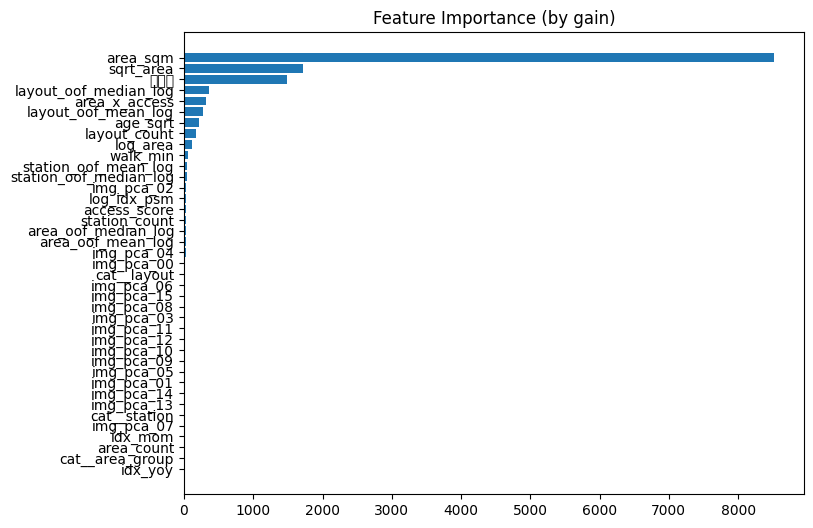

In [22]:
import matplotlib.pyplot as plt

# 重要度を取得
importance = model_point.feature_importance(importance_type="gain")
feature_names = model_point.feature_name()

# DataFrame化
import pandas as pd
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(fi)

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (by gain)")
plt.show()

In [23]:
# ===== ここから追加：学習＆検証（OOF）精度の表示 =====
from sklearn.metrics import r2_score
import numpy as np

def _fmt_metric_row(tag, rmsle, r2, rmse_y, mae_y, mape):
    print(f"[{tag}] RMSLE={rmsle:.4f} | R2(log)={r2:.4f} | RMSE(円)={rmse_y:,.0f} | MAE(円)={mae_y:,.0f} | MAPE={mape:.2f}%")

def _yen_metrics(y_true_yen: np.ndarray, y_pred_yen: np.ndarray):
    rmse_y = float(np.sqrt(np.mean((y_true_yen - y_pred_yen) ** 2)))
    mae_y  = float(np.mean(np.abs(y_true_yen - y_pred_yen)))
    mape   = float(np.mean(np.abs((y_true_yen - y_pred_yen) / np.clip(y_true_yen, 1.0, None))) * 100.0)
    return rmse_y, mae_y, mape

# --- 学習データ上の精度 ---
best_it = getattr(model_point, "best_iteration", None)
y_log_pred_tr = model_point.predict(X_df, num_iteration=best_it)

# deflated のままのRMSE（RMSLE相当）
rmsle_tr = float(np.sqrt(np.mean((y_log - y_log_pred_tr) ** 2)))
r2_tr    = float(r2_score(y_log, y_log_pred_tr))

# ←← 真の価格は必ず y_log_true から戻す！
y_true_yen = np.expm1(y_log_true)

try:
    smear = float(smearing)
except NameError:
    smear = 1.0

if USE_DEFLATE:
    # 予測（相対ログ）に相場ログを足してから円に戻す（★ df[...] ではなく avg_psm_arr を使う）
    yhat_log1p_tr = y_log_pred_tr + np.log(avg_psm_arr)
    y_pred_yen_tr = smear * np.expm1(yhat_log1p_tr)
else:
    y_pred_yen_tr = smear * np.expm1(y_log_pred_tr)

rmse_y_tr, mae_y_tr, mape_tr = _yen_metrics(y_true_yen, y_pred_yen_tr)
_fmt_metric_row("TRAIN", rmsle_tr, r2_tr, rmse_y_tr, mae_y_tr, mape_tr)

# ② KFold OOF（疑似バリデーション）での精度
from sklearn.model_selection import KFold
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
oof_pred_log = np.zeros_like(y_log, dtype=float)

# best_params / best_round / cat_cols / mono_cons は既存の変数を使用
for tr_idx, va_idx in kf.split(X_df):
    X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_tr, y_va = y_log[tr_idx], y_log[va_idx]

     # ★ 追加：重みをfoldごとにスライス
    w_tr = None if 'sample_weight' not in globals() or sample_weight is None else sample_weight[tr_idx]
    w_va = None if 'sample_weight' not in globals() or sample_weight is None else sample_weight[va_idx]

    # ★ ここで weight=... を渡す
    dtr = lgb.Dataset(
        X_tr, label=y_tr, weight=w_tr,
        categorical_feature=cat_cols, free_raw_data=True
    )
    dva = lgb.Dataset(
        X_va, label=y_va, weight=w_va,
        categorical_feature=cat_cols, free_raw_data=True
    )

    params = dict(best_params)
    params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        "monotone_constraints": mono_cons,
    })

    booster = lgb.train(
        params, dtr,
        num_boost_round=best_round,
        valid_sets=[dva],
        callbacks=[],  # ここでは早停なし（best_round固定）
    )
    oof_pred_log[va_idx] = booster.predict(X_va, num_iteration=getattr(booster, "best_iteration", None))

# --- OOF（疑似バリデーション）---
# log空間のRMSE（deflated RMSE）
rmsle_oof = float(np.sqrt(np.mean((y_log - oof_pred_log) ** 2)))
r2_oof    = float(r2_score(y_log, oof_pred_log))

# 円スケール（deflate時は相場ログを足す）
if USE_DEFLATE and (avg_psm_arr is not None):
    y_pred_oof_yen = np.expm1(oof_pred_log + np.log(avg_psm_arr))
else:
    y_pred_oof_yen = np.expm1(oof_pred_log)

y_true_yen = np.expm1(y_log_true)
rmse_y_oof, mae_y_oof, mape_oof = _yen_metrics(y_true_yen, y_pred_oof_yen)
_fmt_metric_row("OOF", rmsle_oof, r2_oof, rmse_y_oof, mae_y_oof, mape_oof)

# === 直近水準の倍率キャリブ（最近 K ヶ月） ===
CALIB_RECENT_K = 2   # ← 好みで 2〜3 を推奨
uniq = np.unique(period_arr)
recent = uniq[-CALIB_RECENT_K:]
mask_recent = np.isin(period_arr, recent)
ratio = y_true_yen[mask_recent] / np.clip(y_pred_oof_yen[mask_recent], 1.0, None)
calib = float(np.median(np.clip(ratio, 0.7, 1.3)))  # クリップは安定化のため
print(f"[Calib] factor={calib:.4f} (recent {CALIB_RECENT_K} months)")

# 参考：キャリブ適用後の円スケール指標も表示
rmse_y_oof_c, mae_y_oof_c, mape_oof_c = _yen_metrics(y_true_yen, calib * y_pred_oof_yen)
_fmt_metric_row("OOF × Calib", rmsle_oof, r2_oof, rmse_y_oof_c, mae_y_oof_c, mape_oof_c)

# 直近重み付き（任意）
if 'sample_weight' in globals() and sample_weight is not None:
    # log側の重み付き誤差
    def _weighted_mean(x, w): return float(np.sum(w*x)/np.sum(w))
    rmsle_oof_w = float(np.sqrt(_weighted_mean((y_log - oof_pred_log)**2, sample_weight)))
    # 円スケール重み付き
    def _yen_metrics_weighted(y_true_yen, y_pred_yen, w):
        rmse_y = float(np.sqrt(_weighted_mean((y_true_yen - y_pred_yen)**2, w)))
        mae_y  = float(_weighted_mean(np.abs(y_true_yen - y_pred_yen), w))
        mape   = float(_weighted_mean(np.abs((y_true_yen - y_pred_yen) / np.clip(y_true_yen, 1.0, None)), w) * 100.0)
        return rmse_y, mae_y, mape
    rmse_y_oof_w, mae_y_oof_w, mape_oof_w = _yen_metrics_weighted(y_true_yen, y_pred_oof_yen, sample_weight)
    rmse_y_oof_w_c, mae_y_oof_w_c, mape_oof_w_c = _yen_metrics_weighted(y_true_yen, calib * y_pred_oof_yen, sample_weight)
    _fmt_metric_row("OOF[w]",   rmsle_oof_w, r2_oof, rmse_y_oof_w,   mae_y_oof_w,   mape_oof_w)
    _fmt_metric_row("OOF[w]×C", rmsle_oof_w, r2_oof, rmse_y_oof_w_c, mae_y_oof_w_c, mape_oof_w_c)

[TRAIN] RMSLE=0.1195 | R2(log)=0.9715 | RMSE(円)=13,255,562 | MAE(円)=8,684,701 | MAPE=9.08%
[OOF] RMSLE=0.1713 | R2(log)=0.9415 | RMSE(円)=18,456,786 | MAE(円)=11,962,527 | MAPE=12.92%
[Calib] factor=1.0105 (recent 2 months)
[OOF × Calib] RMSLE=0.1713 | R2(log)=0.9415 | RMSE(円)=18,412,991 | MAE(円)=11,994,099 | MAPE=13.09%
[OOF[w]] RMSLE=0.1706 | R2(log)=0.9415 | RMSE(円)=18,645,733 | MAE(円)=12,078,724 | MAPE=12.87%
[OOF[w]×C] RMSLE=0.1706 | R2(log)=0.9415 | RMSE(円)=18,584,327 | MAE(円)=12,090,134 | MAPE=13.03%


In [24]:
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import spearmanr

def quick_image_stats(img: Image.Image) -> dict:
    # HSVでざっくり：緑/水/明るさ、S/V
    import numpy as np
    hsv = np.array(img.convert("HSV")).astype(np.float32)
    H = hsv[...,0] / 255.0  # 0-1
    S = hsv[...,1] / 255.0
    V = hsv[...,2] / 255.0

    green = ((H>0.22)&(H<0.45)&(S>0.25)&(V>0.25)).mean()   # 目安
    water = ((H>0.50)&(H<0.70)&(S>0.25)).mean()            # 目安（青～水色）
    return {
        "mean_v": float(V.mean()),
        "mean_s": float(S.mean()),
        "green_ratio": float(green),
        "water_ratio": float(water),
    }

def probe_component_meaning(comp="img_pca_11", sample=40):
    st_pca = pd.read_parquet(EMBED_PARQUET)
    st_geo = pd.read_csv(STATIONS_GEO_CSV)
    df = st_pca.merge(st_geo, on="station", how="inner").dropna(subset=[comp,"lat","lon"])
    # 上位/下位から各20点ずつ取り、簡易統計とSpearman相関
    top = df.nlargest(sample//2, comp)
    bot = df.nsmallest(sample//2, comp)
    sub = pd.concat([top, bot])

    stats = []
    for _, r in sub.iterrows():
        img = fetch_center_patch(float(r["lat"]), float(r["lon"]), z=ZOOM, grid=GRID, crop_px=CROP_PX)
        if img is None: continue
        d = quick_image_stats(img)
        d[comp] = r[comp]
        stats.append(d)

    stat_df = pd.DataFrame(stats)
    for c in ["green_ratio","water_ratio","mean_s","mean_v"]:
        rho, p = spearmanr(stat_df[comp], stat_df[c])
        print(f"{comp} vs {c}: Spearman rho={rho:.3f}, p={p:.3g}")

# 例）img_pca_11 の意味あいを推測
probe_component_meaning("img_pca_11")

img_pca_11 vs green_ratio: Spearman rho=-0.252, p=0.116
img_pca_11 vs water_ratio: Spearman rho=0.105, p=0.519
img_pca_11 vs mean_s: Spearman rho=0.226, p=0.161
img_pca_11 vs mean_v: Spearman rho=-0.072, p=0.659


＃#✅コードの概要
#データ取り込みとクリーニング
元の取引CSV（中央区の実績）から 駅名・徒歩分・面積・築年数・価格 を整形。

「取引時期」から year / month / period(YYYYMM) を作成。

列名の揺れ・表記揺れを吸収して、学習用のきれいな表にする。

#外部指数（平均㎡単価）の生成

別CSV（「平均売買㎡単価推移_東京都中央区.csv」など）から avg_psm_yen（平均㎡単価）を抽出。

月次（YYYYMM）に補間し、MoM/YoY・log指数などの派生特徴も作る。

これを学習データと period でマージして、市場水準（相場）を注入する。

#デフレート（相場調整）設計

価格の対数 y=log1p(price) を、相場(log(avg_psm))を引いた相対ログに置き換えて学習（オプション）。

ねらい：景気や相場全体の上げ下げを先に“取り除く（=デフレート）”ことで、物件固有の要因（面積・駅近・築年数など）を学びやすくする。

最終的な円に戻す時は、予測（相対ログ）＋相場ログ→expm1で復元。

#駅→エリアの付与（地理の離散化）

駅名から 5エリア（銀座・京橋／日本橋・人形町／月島・勝どき・晴海／築地・八丁堀／佃・新川・湊） を自動付与。

地域クラスタをカテゴリ特徴として使う。

#画像特徴（航空写真 × ViT × PCA）

駅名を ジオコーディング（緯度経度） → 国土地理院の航空写真タイルから 駅周辺を512pxで切り出し。

**ViT（画像モデル）**で 768次元の埋め込みを作成 → **PCA(16次元)**に圧縮。

駅ごとの img_pca_00〜15 をテーブルにJOINし、**街並みの質感（緑・水面・密度・明るさなどの“見えない特徴”）**を数値化して学習に活用。

#特徴量エンジニアリング

例：面積の平方根／log、駅近スコア（1/(1+徒歩分)）、面積×駅近 などの派生。

頻度特徴（駅/間取り/エリアの出現回数）。

OOFターゲットエンコーディング（駅/間取り/エリアごとに、fold外の中央値・平均でエンコード）でカテゴリ情報を強化。

外部指数の log_idx_psm, idx_mom, idx_yoy を数値特徴として追加。

#時間に基づく重み付け（サンプルウェイト）

新しい月ほど重く、古い月ほど軽くなる 半減期ウェイト（例：12か月） を付与。

直近の分布に合わせやすくなる。

#モデル学習（Optuna × 時系列CV）

TimeSeriesSplit で古→新の順を守る検証。

Optunaで LightGBMのハイパラ探索（RMSLE最小化）。

単調性制約（徒歩分↓・築年数↓・面積↑ など）を適用して、常識に反しない方向に木の分岐を縛る。

本学習では：

ポイント予測モデル（rmse）

分位点モデル（q10 / q90）（quantile）→ 予測区間を出せる

smearing補正：log→円に戻した時のバイアスを補正する係数を学習残差から推定

#検証とキャリブレーション

学習データ上・KFold OOFで RMSLE / R2(log) / RMSE円 / MAE円 / MAPE を算出。

最近Kか月のOOF結果から中央値比をとり、微小なズレを補正する Calib factor を出す。

さらに外部指数の最新水準に合わせる [CALIB] multiplier to latest も計算（学習末月→最新月の指数比）。

#保存・可視化・解釈

学習済みモデル（ポイント / q10 / q90）、エンコーダや列設定、calibration・use_deflate を保存。

特徴量重要度を出力（どの特徴が効いたかを確認）。

画像PCAの成分の“意味”をざっくり当てるための 相関プローブ（緑比率・水面比率・明るさなどとのSpearman相関を出す補助関数）。

#もう少しだけ各設計の意図

- デフレート：
「価格」=「相場水準」×「物件固有要因」。
先に相場を分離して“物件らしさ”を学ぶと、相場ショックに引っ張られにくい。推論時はふたたび相場を掛け戻すので、現時点の水準に調和する。

- 画像特徴（ViT-PCA）：
価格に効く「目に見えない街の雰囲気（緑地、水辺、建物密度、道路幅、光/影のコントラスト…）」を駅周辺の航空写真から機械的に抽出。駅レベルに集約することで、データの安定性と計算効率を両立。

- 単調性制約：
モデルが「徒歩が遠いほど価格が上がる」みたいな逆転をしにくくし、外れ挙動を抑制。

- 時系列CV＋サンプル重み：
“未来を当てる”検証に寄せる（過去→未来の順序を守る）。さらに直近を重視して最新の傾向にフィット。

- 分位点モデルとsmearing：
ポイント予測だけでなく 区間（q10〜q90）を出す設計。ログ正規っぽい誤差を円に戻す際の平均ズレは smearing で補正。

- 2段キャリブ：
OOFの最近Kヶ月でズレを微調整（モデル側の系統誤差を抑える）。
外部指数の最新水準で倍率を掛け、公表される直近相場への追随性を担保。

#使う人目線での“メンタルモデル”

履歴データを“時系列に正しく評価”しながら、物件固有の要因を学ぶ。

街の見た目（画像）と相場水準（指数）も取り入れ、説明変数の幅を拡張。

予測は 相対価格→相場を掛け戻す→円、最後に直近の微調整をして現実に寄せる。

結果として、安定した精度と直近の整合性を両立し、区間推定で不確実性も提示。

#次に深掘りするなら

デフレートON/OFFの精度比較（RMSLE/MAEの実測差）

画像PCA各成分の意味の検証（上位・下位駅のサンプル可視化）

単調性制約の強弱と特徴量の相互作用

サンプル半減期（6, 12, 18ヶ月）の感度分析

分位点（q05/q95 など）やピンボール損失の最適化

#✅  画像特徴について
1. 今の仕組み
- 1駅につき1枚の航空写真を使っています。
- 駅の緯度経度を中心に、ズーム18でタイルを貼り合わせ → 中央部分を 512×512ピクセル（px） で切り出しています。
- 512px というのは「画像の大きさ」で、縦512ピクセル × 横512ピクセルの四角い画像、という意味です。

2. ViTで特徴抽出
- この画像を Vision Transformer (ViT) に入力すると、
出力として 768次元のベクトル（数値のリスト）が得られます。
これは「街並みの雰囲気を数値化した座標」みたいなものです。
緑が多いか、水辺があるか、建物が密集しているか、などが“暗黙的に”含まれている。

3. PCAで次元圧縮
- 768次元は多すぎるので、そのまま使うと「計算が重い」「ノイズが多い」。
そこで 主成分分析（PCA） で圧縮して、16次元（img_pca_00 〜 img_pca_15）にまとめます。
これで「街並みの要素」を少数の軸に整理し、機械学習モデルに使いやすくしています。

4. テーブルに追加
- こうして作った 16列を、もともとの学習データ（駅名・面積・築年数など）にJOINして、学習に活用しています。
つまり「1駅 = 1枚の航空写真 → 16個の数値特徴」に変換されているわけです。

#✅ モデル学習に使った特徴量
#1. カテゴリ特徴（OrdinalEncoderで数値化）
- cat__area_group（駅を5エリアに分類したカテゴリ）
- cat__station（最寄駅名）
- cat__layout（間取り）

#2. 数値特徴
基本的な数値

- walk_min（徒歩分数）
- 築年数
- area_sqm（面積㎡）

派生数値

- access_score = 1 / (1 + walk_min)
- sqrt_area = √(area_sqm)
- log_area = log1p(area_sqm)
- age_sqrt = √(築年数)
- area_x_access = area_sqm × access_score

出現頻度

- station_count（駅ごとの出現件数）
- layout_count（間取りごとの出現件数）
- area_count（エリアごとの出現件数）

OOFターゲットエンコーディング

- station_oof_median_log
- layout_oof_median_log
- area_oof_median_log
- station_oof_mean_log
- layout_oof_mean_log
- area_oof_mean_log

外部指数（平均㎡単価）

- log_idx_psm（指数の対数値）
- idx_mom（前月比）
- idx_yoy（前年比）

画像特徴（ViT + PCA）

- img_pca_00
- img_pca_01
…
-img_pca_15

（合計16次元）


In [25]:
import time
import numpy as np
import pandas as pd

# These must already be defined in your environment:
# - build_table_and_features()
# - tune_with_optuna(...)
# - train_final_models(...)
# - lgb imported
# - SEED, USE_DEFLATE (global)

def _yen_metrics(y_true_yen: np.ndarray, y_pred_yen: np.ndarray):
    rmse_y = float(np.sqrt(np.mean((y_true_yen - y_pred_yen) ** 2)))
    mae_y  = float(np.mean(np.abs(y_true_yen - y_pred_yen)))
    mape   = float(np.mean(np.abs((y_true_yen - y_pred_yen) / np.clip(y_true_yen, 1.0, None))) * 100.0)
    return rmse_y, mae_y, mape

def _fmt_metric_row(tag, rmsle, r2, rmse_y, mae_y, mape):
    return dict(
        setting=tag,
        RMSLE=round(rmsle, 4),
        R2_log=round(r2, 4),
        RMSE_yen=int(rmse_y),
        MAE_yen=int(mae_y),
        MAPE_pct=round(mape, 2),
    )

def _compute_oof_scores(X_df, y_log, cat_cols, mono_cons, best_params, best_round,
                        sample_weight, avg_psm_arr, y_log_true, period_arr, use_deflate: bool):
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score
    import lightgbm as lgb

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    oof_pred_log = np.zeros_like(y_log, dtype=float)

    for tr_idx, va_idx in kf.split(X_df):
        X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
        y_tr, y_va = y_log[tr_idx], y_log[va_idx]
        w_tr = None if sample_weight is None else sample_weight[tr_idx]
        w_va = None if sample_weight is None else sample_weight[va_idx]

        dtr = lgb.Dataset(X_tr, label=y_tr, weight=w_tr,
                          categorical_feature=cat_cols, free_raw_data=True)
        dva = lgb.Dataset(X_va, label=y_va, weight=w_va,
                          categorical_feature=cat_cols, free_raw_data=True)

        params = dict(best_params)
        params.update({
            "objective": "rmse",
            "metric": "rmse",
            "verbosity": -1,
            "seed": SEED,
            "monotone_constraints": mono_cons,
        })

        booster = lgb.train(params, dtr, num_boost_round=best_round,
                            valid_sets=[dva], callbacks=[])
        oof_pred_log[va_idx] = booster.predict(X_va, num_iteration=getattr(booster, "best_iteration", None))

    # log空間のRMSE
    rmsle_oof = float(np.sqrt(np.mean((y_log - oof_pred_log) ** 2)))
    r2_oof    = float(r2_score(y_log, oof_pred_log))

    # 円スケール
    if use_deflate and (avg_psm_arr is not None):
        y_pred_oof_yen = np.expm1(oof_pred_log + np.log(avg_psm_arr))
    else:
        y_pred_oof_yen = np.expm1(oof_pred_log)

    y_true_yen = np.expm1(y_log_true)
    rmse_y_oof, mae_y_oof, mape_oof = _yen_metrics(y_true_yen, y_pred_oof_yen)
    return rmsle_oof, r2_oof, rmse_y_oof, mae_y_oof, mape_oof

def run_setting(deflate: bool, use_images: bool, n_trials: int = 150, tag: str | None = None):
    global USE_DEFLATE
    old = USE_DEFLATE
    USE_DEFLATE = deflate
    try:
        t0 = time.time()
        X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps, sample_weight, avg_psm_arr, y_log_true, period_arr = build_table_and_features()

        if not use_images:
            img_cols = [c for c in X_df.columns if c.startswith("img_pca_")]
            X_df = X_df.drop(columns=img_cols)
            meta["feat_num"] = [c for c in meta["feat_num"] if not c.startswith("img_pca_")]


        sign_map = {
        "walk_min": -1,     # 駅から遠いほど↓
        "築年数": -1,        # 古いほど↓
        "area_sqm": +1,     # 広いほど↑
        "access_score": +1, # 近いほど↑（walk_minの反対符号）
        "sqrt_area": +1,
        "log_area": +1,
        "age_sqrt": -1,
            # 画像特徴やその他の列は既定で0（制約なし）
         }

        # X_df は [cat..., num...] の順のはず。列名を見て安全に作る
        rebuilt_mono = []
        cat_set = set(cat_cols)
        for col in X_df.columns:
            if col in cat_set:
                rebuilt_mono.append(0)
            else:
                rebuilt_mono.append(sign_map.get(col, 0))

        mono_cons = rebuilt_mono  # 以降はこの制約を使う

        best_params, best_round, best_score = tune_with_optuna(
            X_df, y_log, y_log_true, cat_cols, mono_cons, period_arr,
            n_trials=n_trials, sample_weight=sample_weight, avg_psm=avg_psm_arr
        )

        rmsle_oof, r2_oof, rmse_y, mae_y, mape = _compute_oof_scores(
            X_df, y_log, cat_cols, mono_cons, best_params, best_round,
            sample_weight, avg_psm_arr, y_log_true, period_arr, use_deflate=deflate
        )
        sec = time.time() - t0

        name = tag or f"deflate={'ON' if deflate else 'OFF'} | image={'ON' if use_images else 'OFF'}"
        row = _fmt_metric_row(name, rmsle_oof, r2_oof, rmse_y, mae_y, mape)
        row["best_round"] = int(best_round)
        row["optuna_best_rmsle"] = round(best_score, 4)
        row["minutes"] = round(sec/60.0, 1)
        row["features"] = X_df.shape[1]
        return row
    finally:
        USE_DEFLATE = old

def main():
    settings = [
        (True,  True,  "Deflate ON + Image ON"),
        (True,  False, "Deflate ON + Image OFF"),
        (False, True,  "Deflate OFF + Image ON"),
        (False, False, "Deflate OFF + Image OFF"),
    ]

    rows = []
    for d, im, tag in settings:
        print(f"=== Running: {tag} ===")
        row = run_setting(deflate=d, use_images=im, n_trials=120, tag=tag)
        print(row)
        rows.append(row)

    df = pd.DataFrame(rows).set_index("setting").sort_values("RMSLE")
    print("\\n=== Summary (lower is better for errors) ===")
    print(df)

if __name__ == "__main__":
    main()

=== Running: Deflate ON + Image ON ===


Geocoding stations: 100%|██████████| 26/26 [00:01<00:00, 15.50it/s]
/tmp/ipython-input-3958966287.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")
[I 2025-09-15 12:56:16,002] A new study created in memory with name: no-name-97a89a03-738b-495b-ba7e-7ab3a2a6c332
[I 2025-09-15 12:56:16,235] Trial 0 finished with value: 0.3925510462888343 and parameters: {'learning_rate': 0.05176340429875833, 'num_leaves': 191, 'min_data_in_leaf': 125, 'feature_fraction': 0.8179532731987588, 'bagging_fraction': 0.7694619197355619, 'bagging_freq': 7, 'min_gain_to_split': 2.1879360563134624, 'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881}. Best is trial 0 with value: 0.3925510462888343.
[I 2025-09-15 12:56:16,574] Trial 1 finished with value: 0.25974729557894627 and parameters: {'learning_rate': 0.03154052496956797, 'num_leaves': 209, 'min_d

{'setting': 'Deflate ON + Image ON', 'RMSLE': 0.1717, 'R2_log': 0.9412, 'RMSE_yen': 18526013, 'MAE_yen': 11987040, 'MAPE_pct': 12.97, 'best_round': 402, 'optuna_best_rmsle': 0.1913, 'minutes': 2.1, 'features': 39}
=== Running: Deflate ON + Image OFF ===


Geocoding stations: 100%|██████████| 26/26 [00:01<00:00, 14.38it/s]
/tmp/ipython-input-3958966287.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")
[I 2025-09-15 12:58:24,891] A new study created in memory with name: no-name-91fa6e8b-269f-4c63-913f-9843d156b147
[I 2025-09-15 12:58:25,143] Trial 0 finished with value: 0.3909026163750321 and parameters: {'learning_rate': 0.05176340429875833, 'num_leaves': 191, 'min_data_in_leaf': 125, 'feature_fraction': 0.8179532731987588, 'bagging_fraction': 0.7694619197355619, 'bagging_freq': 7, 'min_gain_to_split': 2.1879360563134624, 'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881}. Best is trial 0 with value: 0.3909026163750321.
[I 2025-09-15 12:58:25,537] Trial 1 finished with value: 0.2600331155506145 and parameters: {'learning_rate': 0.03154052496956797, 'num_leaves': 209, 'min_da

{'setting': 'Deflate ON + Image OFF', 'RMSLE': 0.1717, 'R2_log': 0.9412, 'RMSE_yen': 18515793, 'MAE_yen': 12041630, 'MAPE_pct': 13.0, 'best_round': 209, 'optuna_best_rmsle': 0.1881, 'minutes': 1.1, 'features': 23}
=== Running: Deflate OFF + Image ON ===


Geocoding stations: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s]
/tmp/ipython-input-3958966287.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")
[I 2025-09-15 12:59:30,550] A new study created in memory with name: no-name-d14b8301-5a21-467a-8c54-53e0d9f05dfb
[I 2025-09-15 12:59:30,762] Trial 0 finished with value: 0.39448891980353157 and parameters: {'learning_rate': 0.05176340429875833, 'num_leaves': 191, 'min_data_in_leaf': 125, 'feature_fraction': 0.8179532731987588, 'bagging_fraction': 0.7694619197355619, 'bagging_freq': 7, 'min_gain_to_split': 2.1879360563134624, 'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881}. Best is trial 0 with value: 0.39448891980353157.
[I 2025-09-15 12:59:31,114] Trial 1 finished with value: 0.2623812934503998 and parameters: {'learning_rate': 0.03154052496956797, 'num_leaves': 209, 'min_

{'setting': 'Deflate OFF + Image ON', 'RMSLE': 0.1726, 'R2_log': 0.9409, 'RMSE_yen': 19015221, 'MAE_yen': 12230315, 'MAPE_pct': 13.1, 'best_round': 536, 'optuna_best_rmsle': 0.1926, 'minutes': 1.6, 'features': 39}
=== Running: Deflate OFF + Image OFF ===


Geocoding stations: 100%|██████████| 26/26 [00:01<00:00, 14.07it/s]
/tmp/ipython-input-3958966287.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c] = df[c].fillna(method="ffill").fillna(method="bfill")
[I 2025-09-15 13:01:04,875] A new study created in memory with name: no-name-9afc3385-8a2c-4297-b49a-c0196b211b70
[I 2025-09-15 13:01:05,050] Trial 0 finished with value: 0.39473301368897923 and parameters: {'learning_rate': 0.05176340429875833, 'num_leaves': 191, 'min_data_in_leaf': 125, 'feature_fraction': 0.8179532731987588, 'bagging_fraction': 0.7694619197355619, 'bagging_freq': 7, 'min_gain_to_split': 2.1879360563134624, 'lambda_l1': 1.0615904599004014, 'lambda_l2': 4.709392030276881}. Best is trial 0 with value: 0.39473301368897923.
[I 2025-09-15 13:01:05,317] Trial 1 finished with value: 0.26236164174207677 and parameters: {'learning_rate': 0.03154052496956797, 'num_leaves': 209, 'min

{'setting': 'Deflate OFF + Image OFF', 'RMSLE': 0.1775, 'R2_log': 0.9376, 'RMSE_yen': 19737492, 'MAE_yen': 12553537, 'MAPE_pct': 13.46, 'best_round': 204, 'optuna_best_rmsle': 0.1993, 'minutes': 1.3, 'features': 23}
\n=== Summary (lower is better for errors) ===
                          RMSLE  R2_log  RMSE_yen   MAE_yen  MAPE_pct  \
setting                                                                 
Deflate ON + Image ON    0.1717  0.9412  18526013  11987040     12.97   
Deflate ON + Image OFF   0.1717  0.9412  18515793  12041630     13.00   
Deflate OFF + Image ON   0.1726  0.9409  19015221  12230315     13.10   
Deflate OFF + Image OFF  0.1775  0.9376  19737492  12553537     13.46   

                         best_round  optuna_best_rmsle  minutes  features  
setting                                                                    
Deflate ON + Image ON           402             0.1913      2.1        39  
Deflate ON + Image OFF          209             0.1881      1.1       

In [26]:
miss = X_df.filter(like="img_pca_").isna().any(axis=1).mean()
print("画像JOIN欠損率:", round(100*miss,2), "%")

画像JOIN欠損率: 0.78 %


In [29]:
import glob, numpy as np
from PIL import Image

mask_paths = glob.glob("/content/-__z18_jpg.rf.1d2eada0d650e29ae18e1a895f6437f7_mask.png")[:20]
all_ids = set()
for p in mask_paths:
    with Image.open(p) as im:
        arr = np.array(im) if im.mode == "P" else np.array(im.convert("L"))
        all_ids.update(arr.ravel().tolist())
print("Found class IDs:", sorted(all_ids))  # 例: [0,1,2,3]

Found class IDs: [0, 1, 2, 3]
